In [1]:
%matplotlib inline
from preamble import *

### 2.3.6 결정 트리의 앙상블

앙상블: 여러 머신러닝 모델을 연결하여 더 강려간 모델을 만드는 기법

랜덤포레스트와 그래디언트 부스팅은 둘다 모델을 구성하는 기본요소로 결정트리를 사용

#### 랜덤 포레스트

과대적합되는 결정트리의 단점을 보완

기본적으로 조금씩 다른 여러 결정 트리의 묶음

    - 데이터 일부에 과대적합되는 경향을 줄임
    - 잘 작동하되
        서로 다른 방향으로 과대적합된 트리를
        많이 만들면 
        그 결과를 평균냄으로써
        과대적합된 양을 줄일 수 있다.
        
트리 구성시 무작위성을 주입
    
    - 각 트리의 훈련 데이터 포인트의 무작위성
    - 분할테스트에서 특성을 무작위로 선택

##### 랜덤 포레스트 구축

(1) n_estimators: 트리 개수 지정

(2) 부트스트랩 샘플 생성

    - n_samples 개의 데이터 포인트 중에서
        무작위로 n_samples횟수만큼 반복 추출(중복 허용)
    - 원래 데이터셋 크기와 동일, 일부는 누락, 일부는 중복
    
(3) 결정 트리 생성
    
    - 각 노드에서 최선의 특성을 찾는 대신
        + 각 노드에서 후보 특성을 무작위로 선택
        + 이 후보들 중 최선의 테스트를 선택
        + 몇 개의 특성을 고를지는 max_features 매개변수 사용
        + 후보 특성을 고르는 것은 매 노드마다 반복되므로
            트리의 각 노드는 다른 후보 특성들을 사용하여 테스트 생성

핵심 매개변수는 max_features: 각 노드마다 다른 특성 사용

그러나, max_features = n_features로 설정하면 무작위성 없어짐
max_features = 1이면 각 노드는 무작위 특성 1개를 사용해 테스트 생성
    - max_features 커지면, 트리들이 유사,
        가장 두드러진 특성을 이용해 데이터에 작 맞춰짐
    - max_features를 낮추면 트리가 많이 달라짐.
        각 트리는 데이터에 맞추기 위해 깊이가 깊어짐

예측:
    
    - 모든 트리의 예측 생성
    - 회귀: 이 예측들의 평균
    - 분류: 각 트리가 출력 레이블의 확률을 제공,
        이들을 평균하여 가장 높은 확률을 가진 클래스로 예측

##### 랜덤 포레스트 분석

two_moons 데이터셋, n_estimator = 5

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

만들어진 트리는 estimator_ 속성에 저장

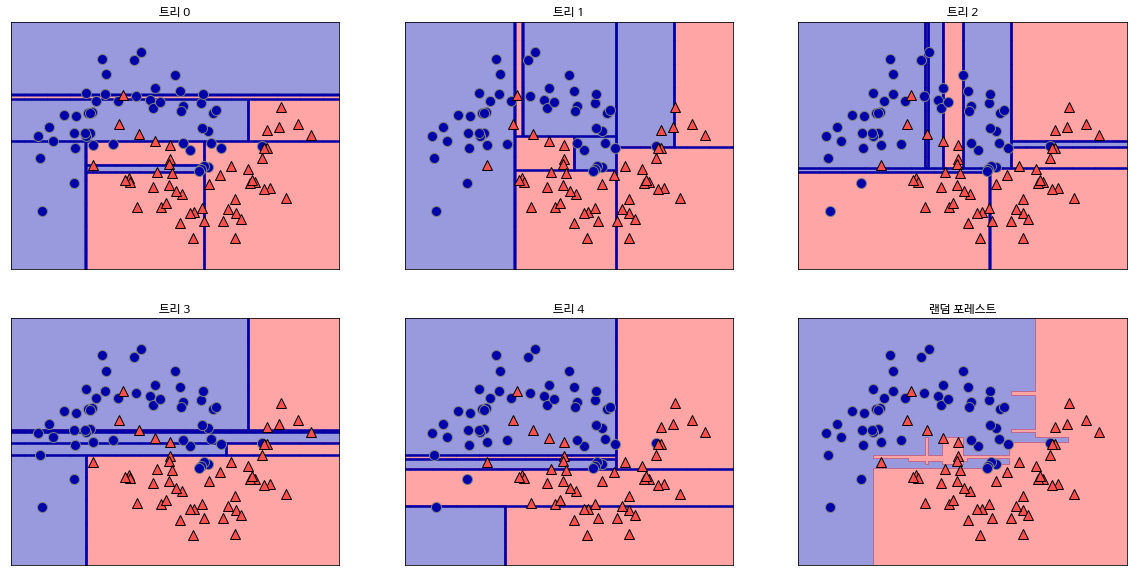

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("트리 {}".format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("랜덤 포레스트")
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

다섯 개의 트리가 만든 결정 경계는 확연하게 다름

부트스트랩의 샘플링 때문에
한쪽에 나타난 데이터가 다른 쪽에는 없을 수 있어 트리가 불완전함

랜덤포레스트는 개개의 트리보다는 덜 과재적합되고 훨씬 좋은 결정 경계 생성
실제는 n_estimator가 수백, 수천 개 이므로 더 부드러운 결졍 경계 생성

유방암 데이터셋에 n_estimator = 100 적용:

In [6]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.972


아무런 매개변수 튜닝 없이도
선형 모델이나 단일 결정 트리보다 높은
97% 정확도를 내고 있음

단일 결정트리에서 한 것처럼
max_features 매개변수를 조정하거나
사전 가지치기를 할 수도 있음

그러나 랜덤포레스트는 기본 설정으로도 좋은 결과 도출

특성 중요도: 하나의 트리에서 제공하는 것보다 더 신뢰할 만함.

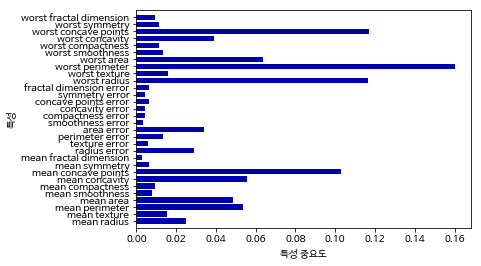

In [8]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(forest)

단일 트리보다 훨씬 많은 특성이 0 이상의 중요도

worst radius보다 worst perimeter가 더 중요

랜덤 포레스트를 만드는 무작위성은
알고리즘이 가능성 있는 많은 경우를 고려할 수 있도록 함
--> 단일 트리보다 더 넓은 시각으로 데잍를 바라볼 수 있음.

##### 장단점과 파라미터

장점:

    - 회귀와 분류에 있어 가장 널리 쓰이는 알고리즘
    - 성능이 매우 뛰어나고, 매개변수 튜닝을 많이 하지 않아도 잘 작동
    - 데이터 스케일을 맞ㅊㄹ 필요도 없음

단점:

    - 트리가 많아 분석하기 어려움
    - 대량의 데이터셋에서는 다소 시간이 걸릴 수 있음
        극복방안: 멀티코어 이용(n_jobs 매개변수)
        n_jobs=-1이면 모든 코어 사용
    - random_state를 지정하지 않으면 무작위성 변동
        + 트리가 많을수록 변동 덜함
        + 같은 결과를 얻고 싶다면 random_state 사용
    - 텍스트 데이터와 같이 차원이 높고, 희소한 데이터에는 잘 작동하지 않음
        + 이러한 모델에는 선형 모델이 더 적합
    - 매우 큰 데이터셋에서도 여러 코어를 이용하여 병렬화 가능하나
        선형모델보다 많은 메모리를 사용하며
        훈련과 예측이 느림

중요 매개변수: n_estimators, max_features, max_depth

    - n_estimators: 클수록 좋음(과대 적합을 줄임)
        한계: 메모리, 긴 훈련시간
    - max_features: 작은 수가 과대적합을 줄임
        일반적으로 디폴트 값을 쓴ㄴ 것이 좋은 방법
        분류: sqrt(n_features), 회귀: n_features
        max_features나 max_leaf_nodes를 쓰면 가끔 성능이 향상되기도 함
        또 훈련과 예측에 필요한 메모리와 시간이 많이 줄어듬

#### 그래디언트 부스팅 회귀 트리

이전 트리의 오차를 보완하는 방식으로 순차적으로 트리 생성
기본적으로 무작위성이 없음.
대신 강력한 사전 가지치기가 사용됨.
1~5개의 깊지 않은 트리를 사용하므로 메모리를 적게 사용하고 예측도 빠름

근본 아이디어:
    약한 학습기를 많이 연결
    각각의 트리는 일부 데이터에 대해서만 예측을 잘 수행
        --> 많이 추가할수록 성능이 좋아짐

그래디언트 부스팅 트리는 머신러닝 경영대회에서 우승을 많이 차지
업계에서도 널리 사용

랜덤포레스트보다 매개변수 설정이 조금 더 민감
    --> 잘 조정하면 더 높은 정확도를 제공

중요 매개변수는 사전가지치기나 
트리 개수 외에도 
이전 트리의 오차를 얼마나 강하게 보정할 것인지 제어하는 learning_rate

학습률이 크면 강하게 보정 --> 복잡한 모델
n_estimators 값을 키우면
    앙상블에 트리가 더 많이 추가되어 복잡도 커짐
    훈련세트의 실수를 더 많이 바로 잡을 수 있음

아래는 유방암 데이터에 적용

    - 매개변수 모두 디폴트
    - max_depth = 3
    - n-estimators = 100
    - learning_rate = 0.1
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.958


훈련 세트의 정확도가 100% --> 과대적합
--> 트리의 깊이를 줄여 사전 가지치기를 강하게 하거나 학습률을 낮출 수 있음.

In [10]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.991
테스트 세트 정확도: 0.972


In [11]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.965


모델의 복잡도를 감소시켜, 정확도가 낮아짐.
학습률 조정 --> 조금 좋아짐
깊이 조정 --> 크게 향상

트리가 100개 이므로 깊이가 1이어도 모든 트리를 분석하기는 쉽지 않음.

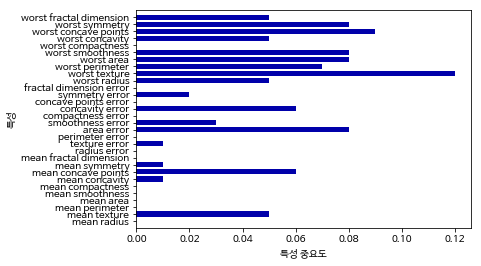

In [12]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

랜덤포레스트와 유사하나, 그래디언트 부스팅은 일부 특성을 완전히 무시함.

비슷한 종류의 데이터에서 그래디언트 부스팅과 랜덤 포레스트 둘다 잘 작동
보통 더 안정적인 랜덤 포레스트를 먼저 적용

**중요 포인트**
랜덤포레스트가 잘 작동하더라도
예측 시간이 중요하거나
머신러닝 모델에서 마지막 성늘까지 쥐어짜야 할 때
그래디언트 부스팅을 사용

대규모 머신러닝 문제에 그래디언트 부스팅을 적용하려면
xgboost 패키지와 파이썬 인터페이스: 빠르고 튜닝도 쉬움

##### 장단점과 파라미터

지도학습에서 가장 널리 사용되는 모델 중 하나

단점:

    - 매개변수를 잘 조정해야 함.
    - 훈련 시간이 김
    - 희소한 고차원 데이터에는 잘 작동하지 않음
    
장점:

    - 특성의 스케일을 조정하지 않아도 됨
    - 이진 특성이나 연속적인 특성에서도 잘 동작    

매개변수
    
    - n_estimator: 트리의 개수를 지정
    - learning_rate: 오차를 보정하는 정도를 조절

이 둘은 매우 깊이 연관:
    learning_rate를 낮추면
    비슷한 복잡도의 모델을 만들기 위해 더 많은 트리 추가
    n_estimator를 크게 하면 모델이 복잡해지고 과대적합될 가능성 높아짐
    (랜덤 포레스트는 n_estimator가 클수록 좋음)
    일반적으로 n_estimator을 시간과 메모리 한도에 맞추고
    learning_rate를 찾음
    
    - max_depth (또는 max_leaf_nodes):
        통상적으로 매우 적게 설정하며, 5보다 깊어지지 않음